To tutaj sprawdza proste parametry żeby sprawdzić czy skrypt działa dobrze.
Bardziej skomplikowane siatki wrzucać na kaggla po dopasowaniu i dobraniu danych -
trzeba zmienić nazwe pliku tutaj niżej

In [34]:
title = 'bagging.1'
data_path = '../dataset.reduced.csv'

In [35]:
"""Wczytanie"""
from pandas import read_csv
df = read_csv(data_path, index_col=0, low_memory=False).drop(columns=['free_month', 'free_year'], axis=1)
X = df.drop('price', axis=1)
y = df['price']
del df

In [36]:
"""Podział"""
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
"""Preproes"""
cat = X.select_dtypes(include='object').columns
fill_med=['year', 'rooms', 'floor']
fill_0=['area_outside', 'rent']
passthrough = [c for c in X.columns if c not in [*fill_med, *fill_0, *cat]]
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
pre = ColumnTransformer(transformers=[
    ('fill_med', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), fill_med),
    ('fill_0', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))]), fill_0),
    ('1hot', Pipeline(steps=[('encoder', OneHotEncoder())]), cat),
    ('passthrough', make_pipeline('passthrough'), passthrough)
])

In [38]:
"""Model"""
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', pre),
    ('baggingRegressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])

In [39]:
"""Walidacja"""
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, train, y_train, cv=3, scoring='neg_mean_absolute_error')

array([-109399.38897025, -108132.89354737, -111901.61370798])

In [40]:
"""Trenowanie"""
pipeline.fit(train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('fill_med',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['year', 'rooms', 'floor']),
                                                 ('fill_0',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['area_outside', 'rent']),
                                                 ('1hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['category',...
                                                   'heating_urban',
                                                   'is_business',
                                                   'rooms_num_more',
                                                   'utility_balcony',
                                                   'utility_closed',
                                                   'utility_connectivity',
                                                   'utility_entryphone',
                                                   'utility_equipment',
                                                   'utility_furniture',
                                                   'utility_garden',
                                                   'utility_lift',
                                                   'utility_media',
                                                   'utility_pool',
                                                   'utility_rollers',
                                                   'utility_security',
                                                   'utility_space'])])),
                ('baggingRegressor',
                 BaggingRegressor(estimator=DecisionTreeRegressor()))])

In [ ]:
"""Migawka modelu"""
import pickle
with open(f'{title}.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [41]:
"""Predykcje"""
from pandas import DataFrame
pred = DataFrame({ 
    'y': [*y, *y_test], 'p': [*pipeline.predict(X), *pipeline.predict(test)], 
    'test': [0] * len(X) + [1] * len(test)
})

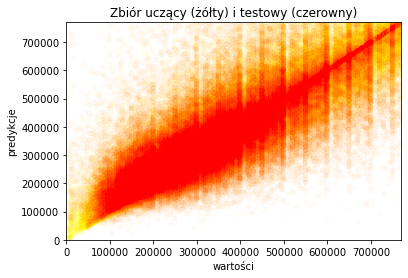

In [42]:
"""Wykres predykcji"""
pred.plot(kind='scatter', 
    title="Zbiór uczący (żółty) i testowy (czerowny)",
    x='y', xlabel='wartości', xlim=(0, pred['y'].quantile(.90)),
    y='p', ylabel='predykcje', ylim=(0, pred['y'].quantile(.90)),
    c=pred['test'].map({0: 'yellow', 1: 'red'}), alpha=.01
);

In [43]:
"""Punktacja"""
from sklearn import metrics
scores = {
    'R2': metrics.r2_score(y_test, pred[pred['test'] == True]['p']),
    'MSE': metrics.mean_squared_error(y_test, pred[pred['test'] == True]['p']),
    'MAE': metrics.mean_absolute_error(y_test, pred[pred['test'] == True]['p']),
    'MAPE': metrics.mean_absolute_percentage_error(y_test, pred[pred['test'] == True]['p'])
}

scores

{'R2': 0.001433873744457359,
 'MSE': 6164253999293.135,
 'MAE': 105396.84788363831,
 'MAPE': 0.27069011814547245}